In [1]:
import cv2
import mediapipe as mp
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


In [2]:
# Paths
c233_path = r'C:\Users\aksh0\Desktop\Hackenza\Quidich-HACKATHON-25\233_im'
c235_path = r'C:\Users\aksh0\Desktop\Hackenza\Quidich-HACKATHON-25\235_im'
intrinsic_path = r'C:\Users\aksh0\Desktop\Hackenza\Quidich-HACKATHON-25\intrinsic.json'
extrinsic_path = r'C:\Users\aksh0\Desktop\Hackenza\Quidich-HACKATHON-25\extrinsic.json'

In [3]:
# Load intrinsic and extrinsic data
with open(intrinsic_path, 'r') as f:
    intrinsic_data = json.load(f)

with open(extrinsic_path, 'r') as f:
    extrinsic_data = json.load(f)

In [4]:
# Extract camera matrices and distortion coefficients
K1 = np.array(intrinsic_data['C233']['camera_matrix'])
D1 = np.array(intrinsic_data['C233']['distortion_coefficients'])
K2 = np.array(intrinsic_data['C235']['camera_matrix'])
D2 = np.array(intrinsic_data['C235']['distortion_coefficients'])

# Extract rotation and translation matrices
R1 = cv2.Rodrigues(np.array(extrinsic_data['rotation_vectors']['C233']))[0]
T1 = np.array(extrinsic_data['translation_vectors']['C233']).reshape(3, 1)
R2 = cv2.Rodrigues(np.array(extrinsic_data['rotation_vectors']['C235']))[0]
T2 = np.array(extrinsic_data['translation_vectors']['C235']).reshape(3, 1)

In [5]:
# Compute projection matrices
P1 = K1 @ np.hstack((R1, T1))
P2 = K2 @ np.hstack((R2, T2))

In [6]:
# MediaPipe setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.1,
    min_tracking_confidence=0.3  # Adjust this value as needed
)
mp_drawing = mp.solutions.drawing_utils

In [7]:
POSE_CONNECTIONS_CUSTOM = frozenset([
    (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER),
    (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW),
    # Add more connections as needed
])

custom_style = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)  # Green for arms
leg_style = mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)     # Red for legs
body_style = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)    # Blue for body


In [8]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        POSE_CONNECTIONS_CUSTOM,
        custom_style,
        custom_style
    )
    
    # Draw legs
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        frozenset([(mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE),
                   (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE),
                   (mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE),
                   (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE)]),
        leg_style,
        leg_style
    )
    
    # Draw body
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        frozenset([(mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP),
                   (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP),
                   (mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP)]),
        body_style,
        body_style
    )


In [9]:
def triangulate_point(P1, P2, point1, point2):
    A = np.array([
        point1[0] * P1[2] - P1[0],
        point1[1] * P1[2] - P1[1],
        point2[0] * P2[2] - P2[0],
        point2[1] * P2[2] - P2[1]
    ])
    _, _, V = np.linalg.svd(A)
    X = V[-1]
    return X[:3] / X[3]

In [10]:
def process_frame(frame_number):
    # Construct file names
    file1 = f"HPUP_033_1_1_1_L_CAM-05_{frame_number:07d}.jpeg"
    file2 = f"HPUP_033_1_1_1_L_CAM-02_{frame_number:07d}.jpeg"

    # Read frames from both cameras
    frame1 = cv2.imread(os.path.join(c233_path, file1))
    frame2 = cv2.imread(os.path.join(c235_path, file2))

    if frame1 is None or frame2 is None:
        print(f"Frame {frame_number} missing in one of the cameras.")
        return None

    # Process frames with MediaPipe
    results1 = pose.process(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    results2 = pose.process(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))

 # Draw styled landmarks on both frames
    if results1.pose_landmarks:
        draw_styled_landmarks(frame1, results1)
    if results2.pose_landmarks:
        draw_styled_landmarks(frame2, results2)




    # Initialize 3D points list
    points_3d = []

    if results1.pose_landmarks and results2.pose_landmarks:
        for i in range(33):  # MediaPipe detects 33 landmarks
            point1 = np.array([results1.pose_landmarks.landmark[i].x * frame1.shape[1],
                               results1.pose_landmarks.landmark[i].y * frame1.shape[0]])
            point2 = np.array([results2.pose_landmarks.landmark[i].x * frame2.shape[1],
                               results2.pose_landmarks.landmark[i].y * frame2.shape[0]])

            # Triangulate 3D point
            point_3d = triangulate_point(P1, P2, point1, point2)
            points_3d.append(point_3d)
    
    #  # Optionally, display or save the processed frames
    # cv2.imshow('Camera 233', frame1)
    # cv2.imshow('Camera 235', frame2)

    return np.array(points_3d)

In [11]:
# Process all frames
all_3d_points = []
for frame_number in range(350, 507,1):  # Start from 1 to 506
    if frame_number % 1 == 0:  # Print every 10 frames
        print(f"Processing frame {frame_number}")
    points_3d = process_frame(frame_number)
   
    # if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
    #     break
    if points_3d is not None:
        all_3d_points.append(points_3d)

Processing frame 350
Processing frame 351
Processing frame 352
Processing frame 353
Processing frame 354
Processing frame 355
Processing frame 356
Processing frame 357
Processing frame 358
Processing frame 359
Processing frame 360
Processing frame 361
Processing frame 362
Processing frame 363
Processing frame 364
Processing frame 365
Processing frame 366
Processing frame 367
Processing frame 368
Processing frame 369
Processing frame 370
Processing frame 371
Processing frame 372
Processing frame 373
Processing frame 374
Processing frame 375
Processing frame 376
Processing frame 377
Processing frame 378
Processing frame 379
Processing frame 380
Processing frame 381
Processing frame 382
Processing frame 383
Processing frame 384
Processing frame 385
Processing frame 386
Processing frame 387
Processing frame 388
Processing frame 389
Processing frame 390
Processing frame 391
Processing frame 392
Processing frame 393
Processing frame 394
Processing frame 395
Processing frame 396
Processing fr

Skipping invalid points array at index 0: []
Skipping invalid points array at index 1: []
Skipping invalid points array at index 2: []
Skipping invalid points array at index 3: []
Skipping invalid points array at index 4: []
Skipping invalid points array at index 5: []
Skipping invalid points array at index 6: []
Skipping invalid points array at index 7: []
Skipping invalid points array at index 8: []
Skipping invalid points array at index 9: []
Skipping invalid points array at index 10: []
Skipping invalid points array at index 11: []
Skipping invalid points array at index 12: []
Skipping invalid points array at index 13: []
Skipping invalid points array at index 14: []
Skipping invalid points array at index 15: []
Skipping invalid points array at index 16: []
Skipping invalid points array at index 17: []
Skipping invalid points array at index 18: []
Skipping invalid points array at index 19: []
Skipping invalid points array at index 20: []
Skipping invalid points array at index 21: [

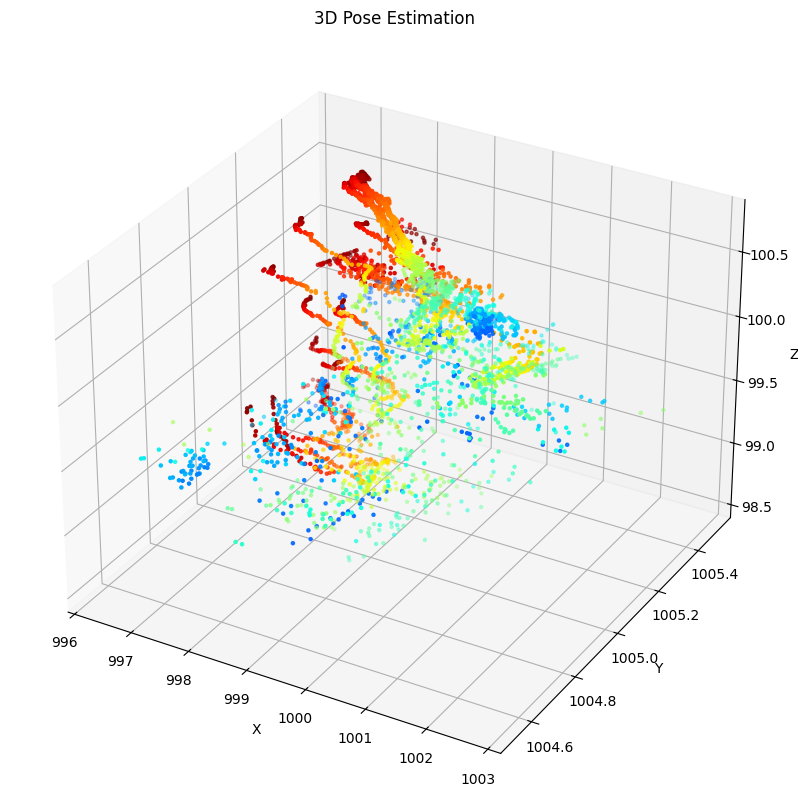

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.jet(np.linspace(0, 1, len(all_3d_points)))

for i, points in enumerate(all_3d_points):
    if points.ndim == 2 and points.shape[1] == 3:  # Check if points are 2D with 3 columns
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=[colors[i]], s=5)
    else:
        print(f"Skipping invalid points array at index {i}: {points}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pose Estimation')

plt.show()

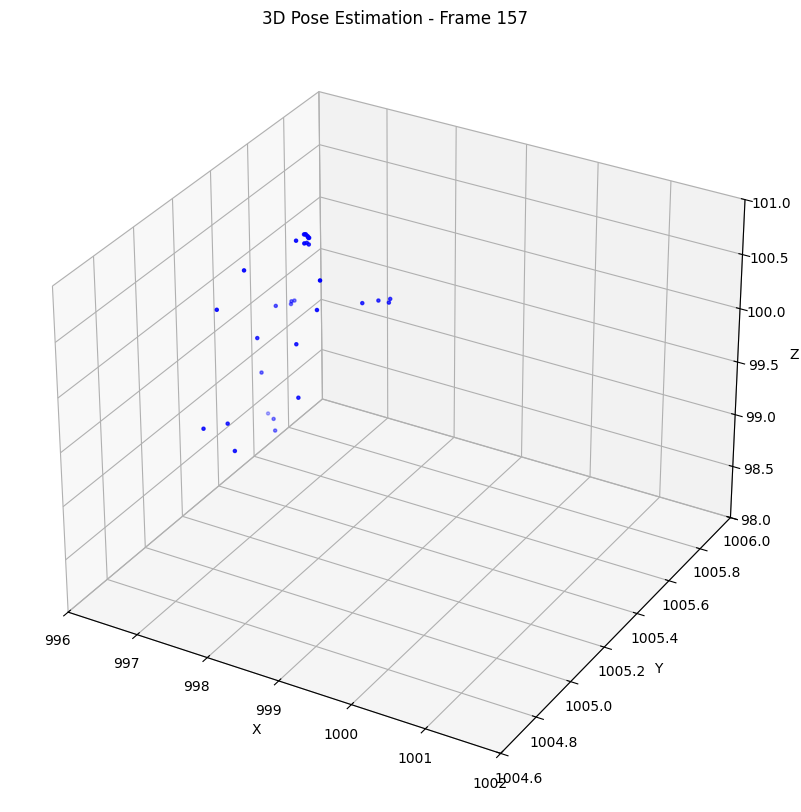

In [13]:
# Set up the figure and 3D axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    points = all_3d_points[frame]
    if points.ndim == 2 and points.shape[1] == 3:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', s=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'3D Pose Estimation - Frame {frame+1}')
    ax.set_xlim([996, 1002])  # Adjust these limits based on your data
    ax.set_ylim([1004.6, 1006])
    ax.set_zlim([98, 101])

# Create the animation
anim = FuncAnimation(fig, update, frames=len(all_3d_points), interval=50, blit=False)

# Save the animation (optional)
anim.save('3d_pose_animation.gif', writer='pillow', fps=4)
plt.show()
plt.close(fig)

# Clean up
cv2.destroyAllWindows()
pose.close()